Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 49s 53ms/step - accuracy: 0.0556 - loss: 6.2275 - val_accuracy: 0.0662 - val_loss: 4.0085 - learning_rate: 0.0010
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.0901 - loss: 3.7368 - val_accuracy: 0.0465 - val_loss: 3.6259 - learning_rate: 0.0010
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.1136 - loss: 3.1295 - val_accuracy: 0.1308 - val_loss: 2.8029 - learning_rate: 0.0010
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.1266 - loss: 2.8764 - val_accuracy: 0.1767 - val_loss: 2.5633 - learning_rate: 0.0010
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.1482 - loss: 2.7281 - val_accuracy: 0.1694 - val_loss: 2.5667 - learning_rate: 0.0010
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.1627 - loss: 2.6282 - val_accuracy: 0.2225 - val_loss: 2.3877 - learning_rate: 0.0010
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.1

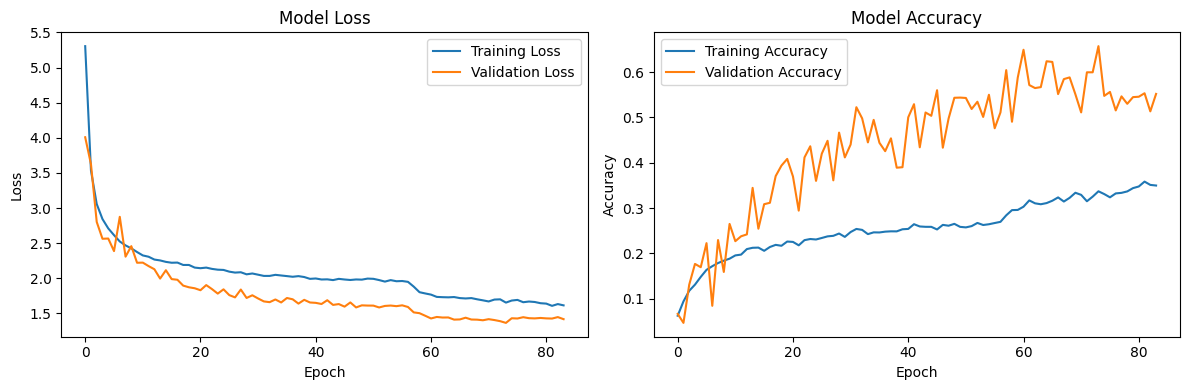

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def load_and_preprocess_data(data_paths, label_paths):
    """
    Load and preprocess multiple data and label files.
    
    Args:
        data_paths (list): List of paths to data files
        label_paths (list): List of paths to label files
    
    Returns:
        tuple: (X, y) preprocessed features and labels
    """
    # Load data files
    data_arrays = [np.load(path) for path in data_paths]
    label_arrays = [np.load(path) for path in label_paths]
    
    # Combine data
    X = np.concatenate(data_arrays)
    y = np.concatenate(label_arrays)
    
    # Preprocess
    X = X / 255.0
    X = X.reshape(-1, X.shape[1], X.shape[2], 1)
    
    return X, y

def create_target_bins(y, num_bins=50):
    """
    Convert continuous target values into discrete bins for classification.
    
    Args:
        y (numpy.ndarray): Array of continuous target values
        num_bins (int): Number of bins to create (default: 50)
    
    Returns:
        tuple: (binned_values, bin_edges)
            - binned_values: Array of integers representing bin indices (0 to num_bins-1)
            - bin_edges: Array of bin boundary values used for converting predictions back to original scale
    """
    bins = np.linspace(0, np.max(y), num_bins)
    y_binned = np.digitize(y, bins) - 1
    return y_binned, bins

def create_model(input_shape, num_classes):
    """
    Create a CNN model for image classification using the functional API.
    
    Architecture:
    - Three ConvBlocks with increasing filters (64->128->256)
    - Each ConvBlock contains:
        * Two Conv2D layers with batch normalization and ReLU
        * MaxPooling (except last block which uses GlobalAveragePooling)
        * Dropout for regularization
    - Dense layer with L2 regularization
    - Final softmax classification layer
    
    Args:
        input_shape (tuple): Shape of input images (height, width, channels)
        num_classes (int): Number of output classes
    
    Returns:
        tf.keras.Model: Compiled CNN model
    """
    inputs = Input(shape=input_shape)
    
    # First ConvBlock
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    # Second ConvBlock
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Third ConvBlock
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    # Dense layers
    x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

def plot_training_history(history):
    """
    Plot training and validation metrics.
    
    Args:
        history: Training history object from model.fit()
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Load and preprocess data
data_paths = [
    '../Data/data0.npy',
    '../Data/data1.npy',
    '../Data/data2.npy'
]
label_paths = [
    '../Data/lab0.npy',
    '../Data/lab1.npy',
    '../Data/lab2.npy'
]

X, y = load_and_preprocess_data(data_paths, label_paths)

# Create bins and convert to categorical
y_binned, bins = create_target_bins(y)
num_classes = len(bins)
y_cat = tf.keras.utils.to_categorical(y_binned, num_classes=num_classes)

# Split data
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

# Create and compile model
model = create_model(X.shape[1:], num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_training_history(history)

# Save the complete model (architecture + weights)
model.save('digit_sum_classification_model.keras')

# Save the bins separately
np.save('bin_edges.npy', bins)